In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.interpolate import interp1d
from scipy.special import expit
from fractions import Fraction
from empiricaldist import Pmf, Cdf
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.formula.api as smfa

In [3]:
from data.utils import prob, update_machine

<AxesSubplot:>

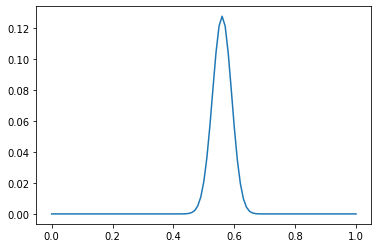

In [5]:
xs = np.linspace(0, 1, 101)
uniform = Pmf(1, xs)
k, n = 140, 250
likelihood = ss.binom(n, xs).pmf(k)
posterior = uniform * likelihood
posterior.normalize()
posterior.plot()

In [7]:
posterior.mean(), posterior.credible_interval(0.9)

(0.5595238095238094, array([0.51, 0.61]))

In [23]:
k = 140
n = 250
# PMF보다 CDF로 확인하는게 개념상 더 맞아보이는데..? 아닌듯..?
like_fair = ss.binom(n, 0.5).pmf(k)
biased = np.linspace(0.55, 0.70, 16)
like_biased = ss.binom(n, biased).pmf(k)
K = like_biased / like_fair
K.round(3)

array([5.776e+00, 6.076e+00, 5.774e+00, 4.953e+00, 3.828e+00, 2.662e+00,
       1.663e+00, 9.300e-01, 4.650e-01, 2.070e-01, 8.200e-02, 2.900e-02,
       9.000e-03, 2.000e-03, 1.000e-03, 0.000e+00])

In [24]:
ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)
imsi = np.append(ramp_up, ramp_down)

<AxesSubplot:>

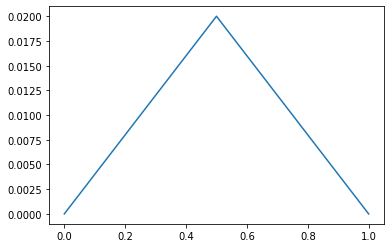

In [25]:
triangle = Pmf(imsi, xs)
triangle.normalize()
triangle.plot()

<AxesSubplot:>

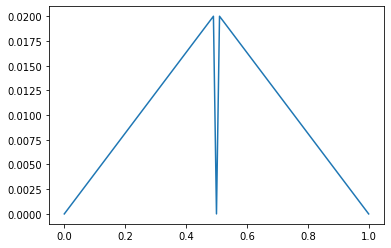

In [26]:
biased_triangle = triangle.copy()
biased_triangle[0.5] = 0
biased_triangle.normalize()
biased_triangle.plot()

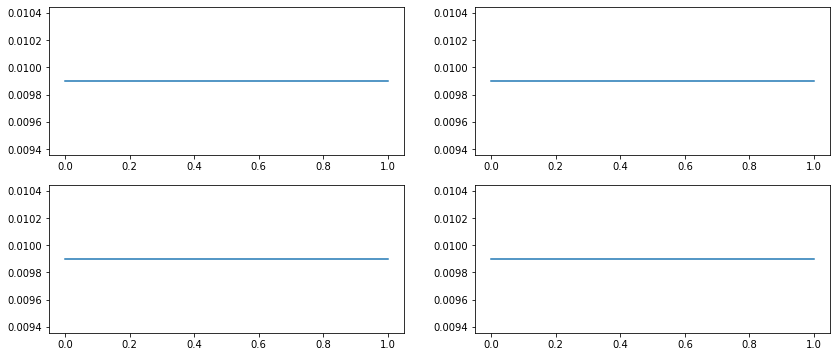

In [27]:
xs = np.linspace(0, 1, 101)
prior = Pmf(1, xs)
prior.normalize()
beliefs = [prior.copy() for i in range(4)]
fig, axs = plt.subplots(2, 2, figsize=(14, 6))
for belief, ax in zip(beliefs, axs.ravel()):
    belief.plot(ax=ax)

<AxesSubplot:>

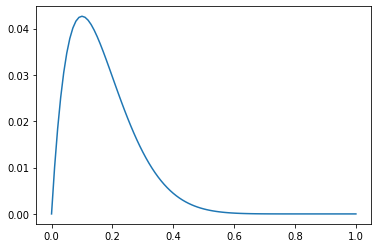

In [28]:
likelihood = {'W':xs, 'L':1 - xs}
bandit = prior.copy()
for outcome in 'WLLLLLLLLL':
    update_machine(bandit, likelihood, outcome)
bandit.plot()

In [39]:
actual_probs = [0.1, 0.2, 0.3, 0.4]
counter = Counter()
# 슬롯머신 i의 실행과 관련된 함수
def play(i):
    if i not in (0, 1, 2, 3):
        raise Exception('0, 1, 2, 3 중 하나를 입력')
    counter[i] += 1
    p = actual_probs[i]
    if np.random.random() < p:
        return 'W'
    else:
        return 'L'
for i in range(4):
    for _ in range(1000):
        outcome = play(i)
        update_machine(beliefs[i], likelihood, outcome)

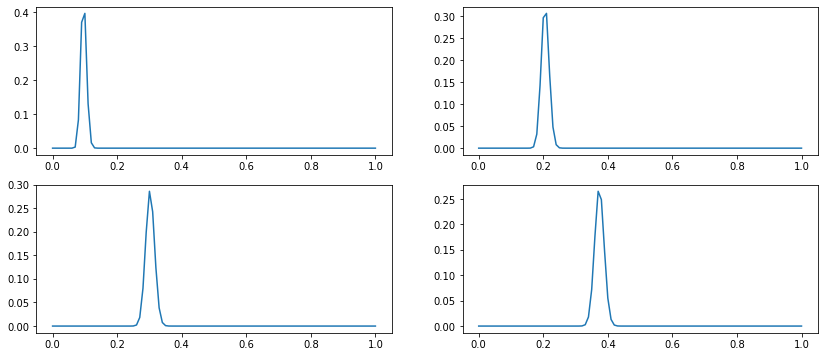

In [40]:
fig, axs = plt.subplots(2, 2, figsize=(14, 6))
for belief, ax in zip(beliefs, axs.ravel()):
    belief.plot(ax=ax)

In [41]:
[(round(belief.mean(), 2), belief.credible_interval(0.9)) for belief in beliefs]

[(0.1, array([0.08, 0.11])),
 (0.21, array([0.19, 0.23])),
 (0.3, array([0.28, 0.32])),
 (0.37, array([0.35, 0.4 ]))]

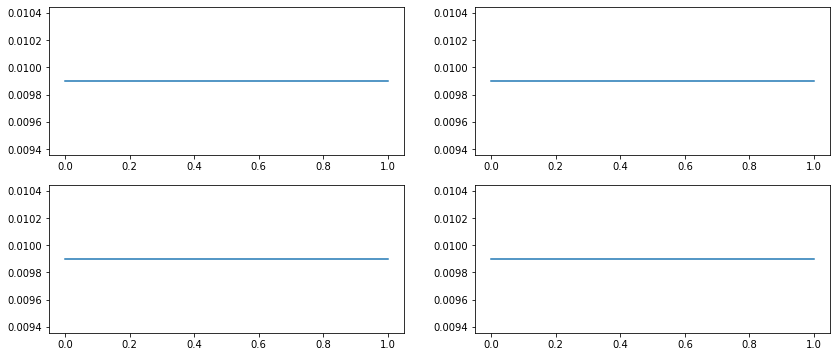

In [53]:
beliefs = [prior.copy() for i in range(4)]
fig, axs = plt.subplots(2, 2, figsize=(14, 6))
for belief, ax in zip(beliefs, axs.ravel()):
    belief.plot(ax=ax)

In [58]:
samples = np.array([b.choice(10) for b in beliefs])
samples.shape, samples

((4, 10),
 array([[0.2 , 0.56, 0.74, 0.02, 0.97, 0.83, 0.82, 0.96, 0.62, 0.4 ],
        [0.55, 0.24, 0.75, 0.72, 0.18, 0.8 , 0.21, 0.7 , 0.35, 0.98],
        [0.11, 0.75, 0.11, 0.03, 0.38, 0.25, 0.03, 0.38, 0.22, 0.9 ],
        [0.88, 0.04, 0.22, 0.44, 0.89, 0.22, 0.98, 0.74, 0.92, 0.66]]))

In [59]:
indices = np.argmax(samples, axis=0)
pmf = Pmf.from_seq(indices)
indices, pmf

(array([3, 2, 1, 1, 0, 0, 3, 0, 3, 1], dtype=int64),
 0    0.3
 1    0.3
 2    0.1
 3    0.3
 Name: , dtype: float64)

In [48]:
def choose_play_update(beliefs):
    def choose(beliefs):
        ps = [b.choice() for b in beliefs]
        return np.argmax(ps)
    machine = choose(beliefs)
    outcome = play(machine)
    update_machine(beliefs[machine], likelihood, outcome)

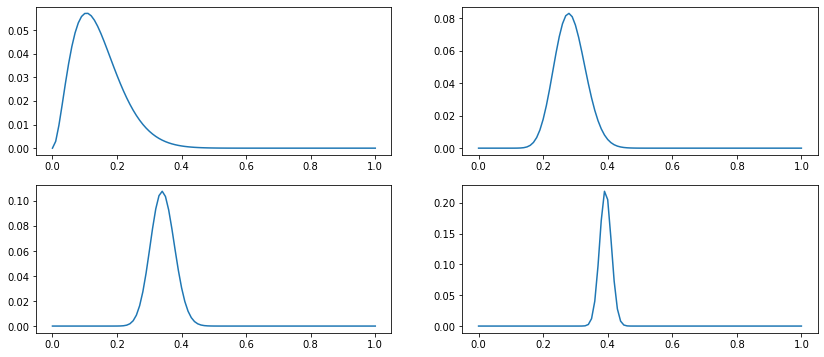

In [49]:
beliefs = [prior.copy() for i in range(4)]
likelihood = {'W':xs, 'L':1 - xs}
counter = Counter()
num_plays = 1000
for i in range(num_plays):
    choose_play_update(beliefs)
fig, axs = plt.subplots(2, 2, figsize=(14, 6))
for belief, ax in zip(beliefs, axs.ravel()):
    belief.plot(ax=ax)

In [50]:
[(round(belief.mean(), 2), belief.credible_interval(0.9)) for belief in beliefs]

[(0.14, array([0.04, 0.28])),
 (0.28, array([0.21, 0.37])),
 (0.34, array([0.28, 0.4 ])),
 (0.39, array([0.36, 0.42]))]

In [52]:
counter

Counter({3: 733, 1: 86, 0: 19, 2: 162})